In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

from datetime import datetime
from datetime import date

In [ ]:
## loading the model

In [8]:
# X = pd.read_csv("../inter_data/X.csv")
# y = pd.read_csv("../inter_data/y.csv")["target"].values
# X = X[[col for col in X.columns if "Unnamed" not in col]]
df_client = pd.read_csv("../../../data/dw_mst_client.csv")
# df_client = df_client[(df_client["data_source"] == "Equity") & (df_client["cm_opendt"] >= 20000101)]

In [ ]:
df_model = df_client[["cm_cd", "IncomePA", "cm_occup", "E2Channel", "IsKarvy", "KRA YN", 
                    "cm_dob", "Last_MobileLoginDate", "LTD"]]

## adding age 
now = datetime.now()
df_model["cm_dob"] = df_model["cm_dob"].astype(str).str.split(".").str[0]
df_model["cm_dob"] = pd.to_datetime(df_model["cm_dob"], errors = "coerce")
df_model["age"] =  (now -df_model["cm_dob"]).astype('<m8[Y]')
del df_model["cm_dob"]
print("age column added!!")


# adding months since last login
df_model["Last_MobileLoginDate"] = df_model["Last_MobileLoginDate"].astype(str).str.split(".").str[0]
df_model["Last_MobileLoginDate"] = pd.to_datetime(df_model["Last_MobileLoginDate"], errors = "coerce")
df_model["months_since_last_login"] =  (now -df_model["Last_MobileLoginDate"])/np.timedelta64(1, 'M')
del df_model["Last_MobileLoginDate"]
df_model["months_since_last_login"] = df_model["months_since_last_login"].fillna(132)
print("month since last login added")

# adding months since last trade - futures
df_model["LTD"] = df_model["LTD"].astype(str).str.split(".").str[0]
df_model["LTD"] = pd.to_datetime(df_model["LTD"], errors = "coerce")
df_model["months_since_last_trade"] =  (now -df_model["LTD"])/np.timedelta64(1, 'M')
del df_model["LTD"]
df_model["months_since_last_trade"] = df_model["months_since_last_trade"].fillna(132)
print("month since last trade added")

## adding trades and logins in one year

df_logins_one_year = pd.read_csv("../../../data/avg_logins_last_year.csv") 
df_model.rename(columns = {"ClientCode": "client_code"}, inplace = True)
df_model = pd.merge(df_model, df_logins_one_year, 
                   left_on = "cm_cd", 
                   right_on = "ClientCode", how = "left")[list(df_model.columns) + ["avg_logins"]]
df_model["total_logins_one_year"] = df_model["avg_logins"].fillna(0)*12
del df_model["avg_logins"]
print("logins added !!")

df_trades_one_year = pd.read_csv("../../../data/avg_trades_last_year.csv") 
df_model = pd.merge(df_model, df_trades_one_year, 
                   left_on = "cm_cd", 
                   right_on = "Client_Code", how = "left")[list(df_model.columns) + ["avg_trades"]]
df_model["total_trades_one_year"] = df_model["avg_trades"].fillna(0)*12
del df_model["avg_trades"]
print("trades added !!")

df_thv = pd.read_csv("../../../data/THV_all_clients_20211126.csv")
df_model = pd.merge(df_model, 
                   df_thv, 
                   left_on = "cm_cd", right_on = "client_code", 
                   how = "left")[list(df_model.columns) +  ["dp_holding"]]
df_model["dp_holding"].fillna(0)
df_model["dp_holding"] = df_model["dp_holding"].fillna(0)
print("dp holdng added!!")





In [ ]:
df_model = df_model[X.columns]

In [ ]:
def feature_engineering_catboost(df):
    # handing null values(continuos values)
    df["months_since_last_login"] = df["months_since_last_login"].fillna(df["months_since_last_login"].mean())
    df["months_since_last_trade"] = df["months_since_last_trade"].fillna(df["months_since_last_trade"].mean())
    
    
    # categorical data
    df["KRA YN"] = df["KRA YN"].fillna("N")
    
    income_slabs = list(df["IncomePA"].value_counts().index[:5])
    df["IncomePA"] = df["IncomePA"].replace({"5_10L ??": "5_10L", 
                                        "<=1??": "<=1L", 
                                        "1_5??": "1_5L", "<= 1L": "<=1L"})
    df['IncomePA'].loc[~df['IncomePA'].isin(income_slabs)] = 'others'
    
    e2channels = list(df["E2Channel"].value_counts().index[:5])
    df['E2Channel'].loc[~df['E2Channel'].isin(e2channels)] = 'others'
    
    occups = list(df["cm_occup"].value_counts().index[:5])
    df['cm_occup'].loc[~df['cm_occup'].isin(occups)] = 'others'
    
    df['IsKarvy'] = df['IsKarvy'].fillna(0)
    
    
   
    # scaling numerical columns
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    numerical_cols = ["age","months_since_last_login","months_since_last_trade", "total_logins_one_year", 
                      "total_trades_one_year"]

    df[numerical_cols] = df[numerical_cols].fillna(0)

-    return df


In [ ]:
df = feature_engineering_catboost(df_model.copy())
df_model = df.copy()
del df["cm_cd"]

In [4]:
from catboost import CatBoostClassifier
clf_cat = CatBoostClassifier()
clf_cat.load_model('../models/catboost_classifier')
# preds = pd.concat([pd.DataFrame(clf_cat.predict_proba(df)), 
#                   pd.DataFrame(clf_cat.predict(df))], axis = 1)
# df_pred = pd.DataFrame({"client_code": df_model["cm_cd"], 
#                        "probability": preds.iloc[:, 1], 
#                        "prediction": preds.iloc[:, 2]})

In [ ]:
df_refers = df_pred[df_pred["prediction"] == 1]
df_refers.loc[(df_refers['probability'] >= 0.5) & (df_refers['probability'] <= 0.75), 'prediction'] = "low"
df_refers.loc[(df_refers['probability'] >= 0.75) & (df_refers['probability'] <= 0.85), 'prediction'] = "medium"
df_refers.loc[(df_refers['probability'] >= 0.85) & (df_refers['probability'] <= 1), 'prediction'] = "high"
del df_refers["probability"]

In [ ]:
df_refers["prediction"].value_counts()

In [ ]:
df_refers.to_csv("../results/all_clients_preds_refers.csv")

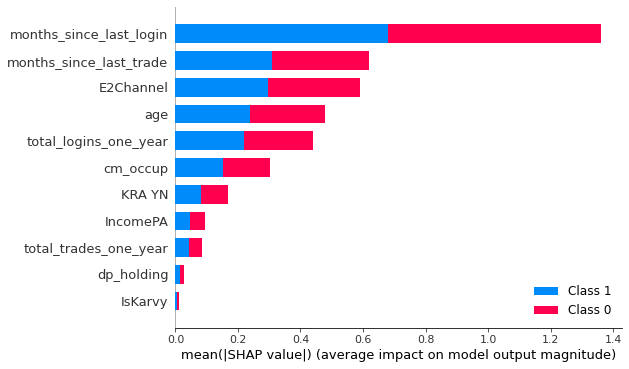

In [6]:
import shap

explainer = shap.TreeExplainer(clf_cat)
shap_values = explainer.shap_values(X.iloc[:, 2:])

# visualize the first prediction's explanation
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
shap.summary_plot(shap_values, X.iloc[:, 2:])


In [ ]:
!pip install shap

In [5]:
X

Unnamed: 0     cm_cd IncomePA cm_occup   E2Channel  IsKarvy KRA YN  \
0               1  11154521     <=1L        P         CAT        0      N   
1               2  SHIRAZUI    5_10L        P         CAT        0      Y   
2               3  11975396     1_5L        S         CAT        0      N   
3               4  MSHAHRO7     <=1L        S         CAT        0      N   
4               5  24276798     <=1L        S         CAT        0      Y   
...           ...       ...      ...      ...         ...      ...    ...   
54105       62876  11288787    5_10L        P         CAT        0      Y   
54106       62877  92516982     1_5L        S         CAT        0      N   
54107       62878  17482977    5_10L        P         CAT        0      N   
54108       62879  70629679     <=1L        S         CAT        0      Y   
54109       62881  1122HARI     <=1L   others  Franchisee        0      N   

        age  months_since_last_login  months_since_last_trade  dp_holding  \
0      23.0               132.000000               132.000000         0.0   
1      21.0                 6.133384                 0.515198         0.0   
2      44.0               132.000000               132.000000         0.0   
3      22.0                20.359548               132.000000         0.0   
4      42.0                 0.515198                 0.810892         0.0   
...     ...                      ...                      ...         ...   
54105  27.0                 1.106591               132.000000         0.0   
54106  35.0               132.000000               132.000000         0.0   
54107  72.0                 0.515198                 0.745183         0.0   
54108  19.0                 0.778038                 0.810892         0.0   
54109  64.0                14.577093                 0.548058    260015.0   

       total_logins_one_year  total_trades_one_year  
0                        0.0                    0.0  
1                       13.0                    1.0  
2                        0.0                    0.0  
3                        0.0                    0.0  
4                       93.0                    6.0  
...                      ...                    ...  
54105                   10.0                    0.0  
54106                    0.0                    1.0  
54107                 1400.0                   56.0  
54108                    6.0                    1.0  
54109                  403.0                   70.0  

[54110 rows x 13 columns]

In [11]:
df_client

cm_cd               cm_name cm_sex    cm_dob cm_introducer  \
0        --977768          BIPINCHANDRA      F  19750503     FY173AP01   
1        --977768          BIPINCHANDRA      F  19750503     FY173AP01   
2        --977768          BIPINCHANDRA      F  19750503     FY173AP01   
3        00000001          ARJUN  SINGH      M  19840101       C105135   
4        00000001          ARJUN  SINGH      M  19840101       C105135   
...           ...                   ...    ...       ...           ...   
3502109  ZZZSANDE        SANDEEP  KUMAR      M  19881114        C32115   
3502110  ZZZSANDE        SANDEEP  KUMAR      M  19881114        C32115   
3502111  ZZZXXX33  GARIMA  SANGAMNERKAR      F  19741203        C84574   
3502112  ZZZZAMIT            AMIT GUPTA      M  19861127        C58690   
3502113  ZZZZZZZZ         RAKHI  WADHWA      F  19890817       C150153   

        cm_subbroker cm_groupcd cm_billflag cm_dpid  cm_dpactno cm_type  \
0                NaN  FY173AP01           A     NaN         NaN       S   
1                NaN  FY173AP01           A     NaN         NaN       S   
2                NaN  FY173AP01           A     NaN         NaN       S   
3                NaN     C17279           A     NaN         NaN       S   
4                NaN     C17279           A     NaN         NaN       S   
...              ...        ...         ...     ...         ...     ...   
3502109          NaN  FI210AP27           A     NaN         NaN       S   
3502110          NaN  FI210AP27           A     NaN         NaN       S   
3502111        F1304    F130401           A     NaN         NaN       S   
3502112          NaN  FU312AP02           A     NaN         NaN       S   
3502113          NaN    C145696           A     NaN         NaN       S   

        cm_brkggroup cm_currencycd  cm_servicetax  cm_opendt  cm_lastlogindt  \
0                              INR            5.0   20210611             NaN   
1                              INR            5.0   20210611             NaN   
2                              INR            5.0   20210611             NaN   
3                              INR            5.0   20120620             NaN   
4                              INR            5.0   20120620             NaN   
...              ...           ...            ...        ...             ...   
3502109                        INR            5.0   20120716             NaN   
3502110                        INR            5.0   20120716             NaN   
3502111                        INR            5.0   20110228             NaN   
3502112                        INR            5.0   20130412             NaN   
3502113                        INR            5.0   20181030             NaN   

           mkrid     mkrdt cm_freezeyn  cm_freezedt  \
0            SYS  20210611           N     19000101   
1            SYS  20210611           N     19000101   
2            SYS  20210611           N     19000101   
3          SUDHA  20120620           N     19000101   
4          SUDHA  20120620           N     19000101   
...          ...       ...         ...          ...   
3502109    C3503  20140930           N     19000101   
3502110    C3503  20140930           N     19000101   
3502111   C33931  20150320           Y     20150324   
3502112   NIDHIN  20130412           N     19000101   
3502113  c150153  19000101           Y     20190620   

                                cm_freezereason cm_brboffcode cm_sebino  \
0                                           NaN        BM1573       NaN   
1                                           NaN        BM1573       NaN   
2                                           NaN        BM1573       NaN   
3                                           NaN         BM849       NaN   
4                                           NaN         BM849       NaN   
...                                         ...           ...       ...   
3502109                                     NaN         BM160       NaN   
